In [150]:
#Most of these will be removed before the final submission. They are holdovers from the code I used to make this.
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns


from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold

from sklearn.neural_network import MLPClassifier
from sklearn import neural_network
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import math
import csv
import os

In [151]:
#Get the current path where the code is saved
path = os.getcwd()

#Change working directory for Python to the location where the code is saved
os.chdir(path)

#Read the excel file with data. Make sure it is saved in the same location as the code!!
data = pd.read_excel("Airbnb_Open_Data.xlsx")


In [152]:
#Give a description of the data that was loaded
print("\nHead:\n",data.head())
print("\n\nDescription:\n",data.price.describe())



Head:
                                                NAME host_identity_verified  \
0                Clean & quiet apt home by the park            unconfirmed   
1                             Skylit Midtown Castle               verified   
2               THE VILLAGE OF HARLEM....NEW YORK !            unconfirmed   
3  Entire Apt: Spacious Studio/Loft by central park               verified   
4         Large Cozy 1 BR Apartment In Midtown East               verified   

  neighbourhood group neighbourhood  instant_bookable cancellation_policy  \
0            Brooklyn    Kensington             False              strict   
1           Manhattan       Midtown             False            moderate   
2           Manhattan        Harlem              True            flexible   
3           Manhattan   East Harlem             False            moderate   
4           Manhattan   Murray Hill              True            flexible   

         room type  Construction year  price  service fee  m

In [153]:
#Create a dataframe with the new data,
frame=DataFrame(data)

#Assign columns 2-18 as variable X. X will represent the independent variables we will use to make predictions.
X = data.iloc[:,1:17]
              
#Display the data types of all columns
print(X.dtypes)

host_identity_verified                    object
neighbourhood group                       object
neighbourhood                             object
instant_bookable                            bool
cancellation_policy                       object
room type                                 object
Construction year                        float64
price                                    float64
service fee                              float64
minimum nights                           float64
number of reviews                        float64
last review                       datetime64[ns]
reviews per month                        float64
review rate number                       float64
calculated host listings count           float64
availability 365                         float64
dtype: object


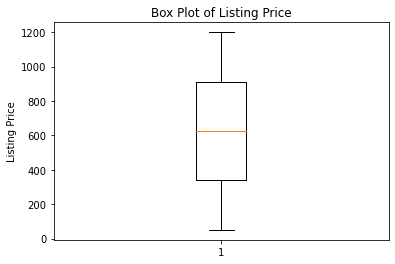

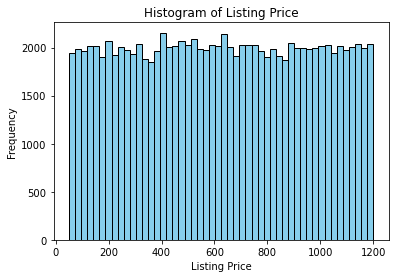

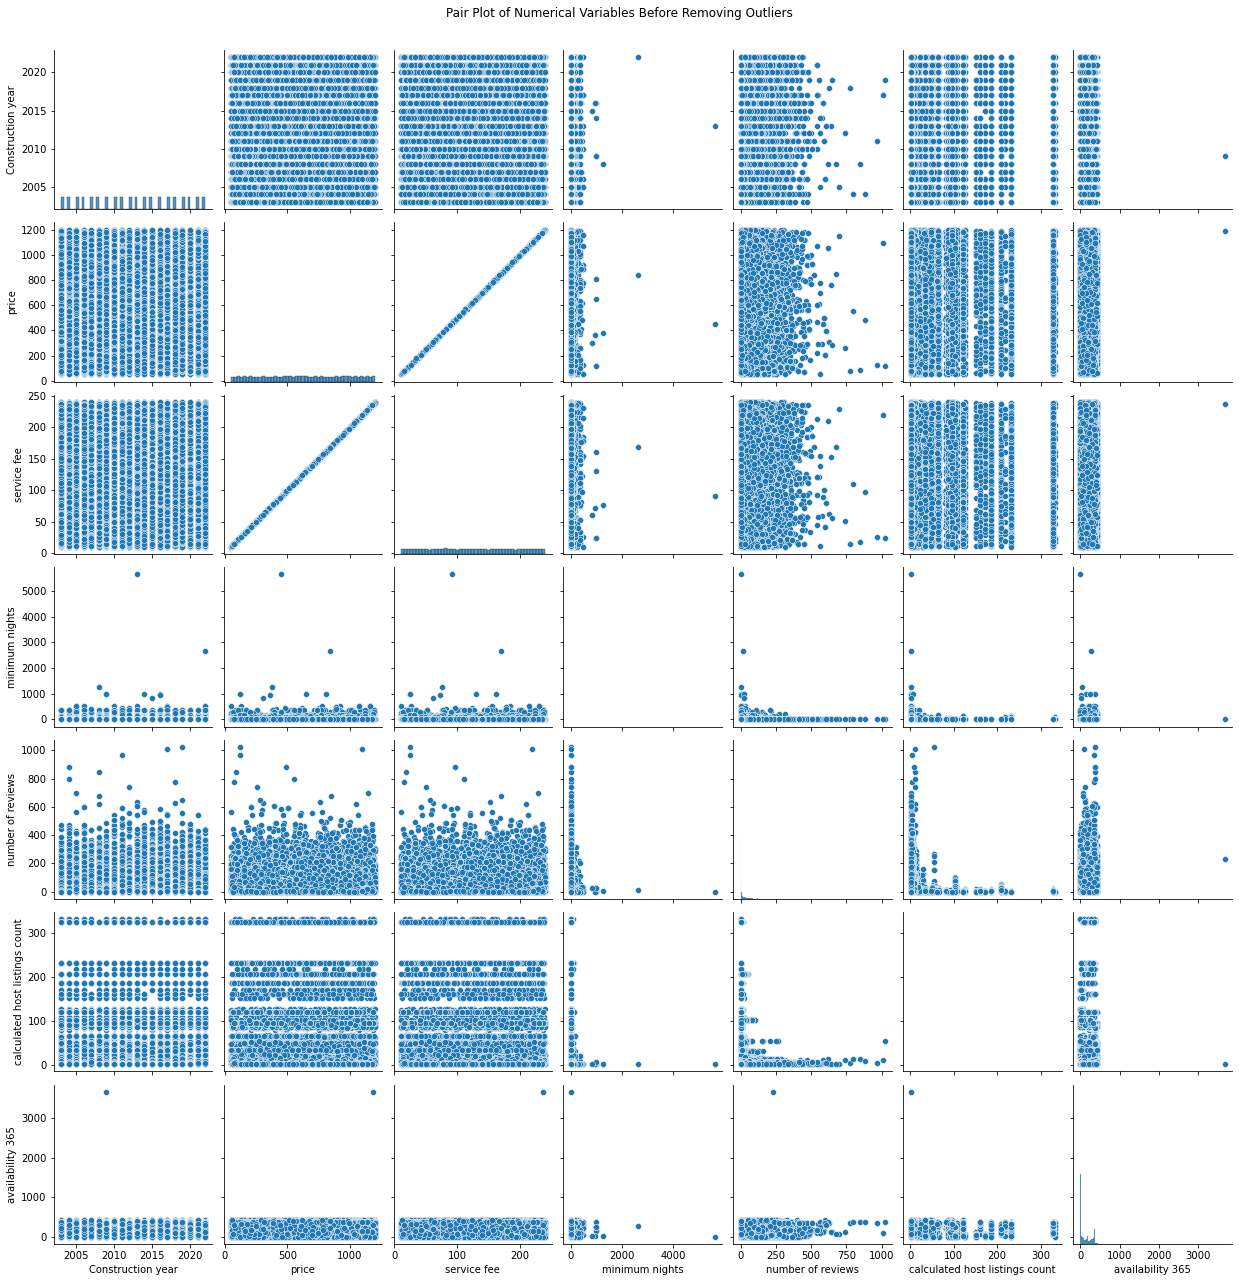

In [154]:
#Create the box plot
plt.boxplot(data.price)

#Add labels and title
plt.title('Box Plot of Listing Price')
plt.ylabel('Listing Price')

#Display the plot
plt.show()

#Create the histogram
plt.hist(data.price, bins=50, color='skyblue', edgecolor='black')

#Add labels and title
plt.xlabel("Listing Price")
plt.ylabel("Frequency")
plt.title("Histogram of Listing Price")

#Display the plot
plt.show()

#Create a dataset of numerical variables for the pair plot
X_pairplot = X.drop(columns=['last review', 'reviews per month', 'review rate number', 'host_identity_verified', 'neighbourhood group', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 'room type'])

sns.pairplot(X_pairplot)
plt.suptitle("Pair Plot of Numerical Variables Before Removing Outliers", y=1.02) # Adjust title position
plt.show()


In [4]:
#If un-commented, this statement can be used to show how many columns are in X.
#print("\n\nX: \n",len(X.iloc[0,:]))

In [155]:
#Remove outliers

#Calculate Z-scores for each column
z_scores = np.abs(stats.zscore(X_pairplot))

#Length before filtering outliers
print("Length before filtering outliers",len(X))

#Filter out rows where any column has an absolute Z-score greater than 3. Use only numberic columns from the pairplot dataframe. Save the index of each row to keep so the remainder can be dropped from the combined dataframe X.
X_keep_rows = X_pairplot[(z_scores < 3).all(axis=1)].index

#Use location of rows without outliers to select rows from X to keep. 
X = X.loc[X_keep_rows]

#Length before filtering outliers
print("Length after filtering outliers",len(X))

Length before filtering outliers 99715
Length after filtering outliers 95277


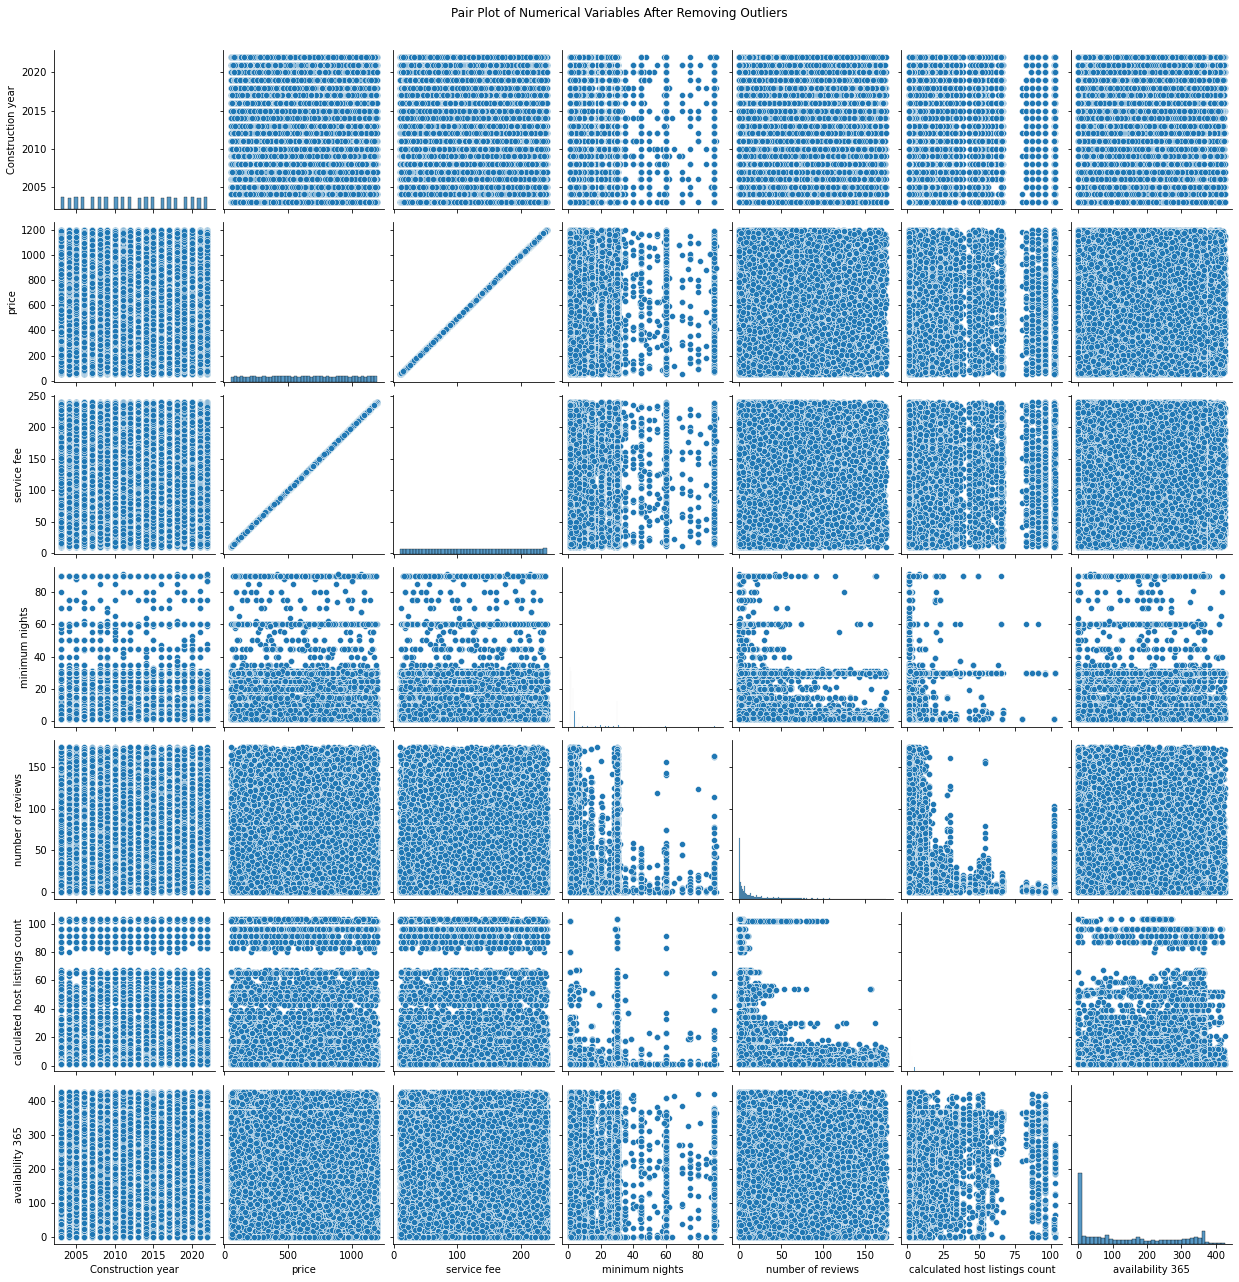

In [156]:
#Re-do pairplot after removing outliers

#Create a dataset of numerical variables for the pair plot
X_pairplot = X.drop(columns=['last review', 'reviews per month', 'review rate number', 'host_identity_verified', 'neighbourhood group', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 'room type'])

sns.pairplot(X_pairplot)
plt.suptitle("Pair Plot of Numerical Variables After Removing Outliers", y=1.02) # Adjust title position
plt.show()

In [157]:
#Assign the "price" variable to y. y will represent the dependent variable for which we are solving.
y = X.price

#Remove columns that will not be used in this analysis. We need to drop "price" and anything having to do with reviews for the main data set.  The weighted regression will require the number of reviews to remain.
#X = X.drop(columns=['last review', 'reviews per month', 'number of reviews', 'review rate number', 'price'])
X = X.drop(columns=['last review', 'reviews per month', 'review rate number'])


In [158]:
#Initialize the MinMaxScaler to scale number of reviews for wreighted regression
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
#X_weighted['number of reviews'] = scaler.fit_transform(X_weighted[['number of reviews']])
X['number of reviews'] = scaler.fit_transform(X[['number of reviews']])

#Drop price column
X = X.drop(columns=['price'])

#X_weighted.head()
X.head()

,host_identity_verified,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,Construction year,service fee,minimum nights,number of reviews,calculated host listings count,availability 365
0,unconfirmed,Brooklyn,Kensington,False,strict,Private room,2020.0,193.0,10.0,0.051724,6.0,286.0
1,verified,Manhattan,Midtown,False,moderate,Entire home/apt,2007.0,28.0,30.0,0.258621,2.0,228.0
2,unconfirmed,Manhattan,Harlem,True,flexible,Private room,2005.0,124.0,3.0,0.000000,1.0,352.0
3,verified,Manhattan,East Harlem,False,moderate,Entire home/apt,2009.0,41.0,10.0,0.051724,1.0,289.0
4,verified,Manhattan,Murray Hill,True,flexible,Entire home/apt,2013.0,115.0,3.0,0.425287,1.0,374.0


In [159]:
#Create dummy variables for columns with character data types
X = pd.get_dummies(X, columns=['host_identity_verified', 'neighbourhood group', 'neighbourhood', 'instant_bookable', 'cancellation_policy', 'room type'])

#Show details about the dataset after adding dummy variables
X.head()

,Construction year,service fee,minimum nights,number of reviews,calculated host listings count,availability 365,host_identity_verified_unconfirmed,host_identity_verified_verified,neighbourhood group_Bronx,neighbourhood group_Brooklyn,...,neighbourhood_Woodside,instant_bookable_False,instant_bookable_True,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,room type_Entire home/apt,room type_Hotel room,room type_Private room,room type_Shared room
0,2020.0,193.0,10.0,0.051724,6.0,286.0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2007.0,28.0,30.0,0.258621,2.0,228.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
2,2005.0,124.0,3.0,0.000000,1.0,352.0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,2009.0,41.0,10.0,0.051724,1.0,289.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
4,2013.0,115.0,3.0,0.425287,1.0,374.0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0


In [178]:
#Split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=34)

In [8]:
#If un-commented, these statements can be used to confirm that the X and y sets created are the correct length. This is useful in troubleshooting.
#print(len(X_train))
#print(len(X_train))
#print(len(X_test))
#print(len(y_test))

In [179]:
#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Initialize Lasso model
lasso = Lasso(random_state=34)

#Define a range of alpha values to search
param_grid = {'alpha': np.logspace(-4, 0, 50)}

#Use GridSearchCV to find the optimal alpha using cross-validation
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

#Get the best Lasso model
best_lasso = grid_search.best_estimator_
print(f"Best alpha: {best_lasso.alpha}")

#Access the coefficients
coefficients = best_lasso.coef_
feature_names = X.columns

#Identify selected features (non-zero coefficients)
selected_features = feature_names[coefficients != 0]
discarded_features = feature_names[coefficients == 0]

#Print details about the features and coefficients that were selected
print(f"\n\nSelected Features: {list(selected_features)}")
#print(f"\n\nDiscarded Features: {list(discarded_features)}")
print(f"\n\nCoefficients: {dict(zip(feature_names, coefficients))}")

#Evaluate the model
y_pred = best_lasso.predict(X_test_scaled)


MAE_lasso = mean_absolute_error(y_test, y_pred)
RMSE_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_lasso = metrics.mean_squared_error(y_test, y_pred)
R2_lasso = metrics.r2_score(y_test, y_pred)


Best alpha: 0.009102981779915217


Selected Features: ['service fee', 'neighbourhood_Allerton', 'neighbourhood_Belmont', 'neighbourhood_Bergen Beach', 'neighbourhood_Breezy Point', 'neighbourhood_Briarwood', 'neighbourhood_Bronxdale', 'neighbourhood_Brooklyn Heights', 'neighbourhood_Cambria Heights', 'neighbourhood_Chinatown', 'neighbourhood_Co-op City', 'neighbourhood_Concord', 'neighbourhood_Crown Heights', 'neighbourhood_East Flatbush', 'neighbourhood_East Morrisania', 'neighbourhood_Eltingville', 'neighbourhood_Emerson Hill', 'neighbourhood_Far Rockaway', 'neighbourhood_Fordham', 'neighbourhood_Gerritsen Beach', 'neighbourhood_Gowanus', 'neighbourhood_Howland Hook', 'neighbourhood_Jackson Heights', 'neighbourhood_Kips Bay', 'neighbourhood_Long Island City', 'neighbourhood_Norwood', 'neighbourhood_Olinville', 'neighbourhood_Parkchester', 'neighbourhood_Pelham Bay', 'neighbourhood_Prospect Heights', 'neighbourhood_SoHo', 'neighbourhood_Soundview', 'neighbourhood_South Beach', 'neighb

In [180]:
print("\nIndependent variable training set length before feature selection:\n",len(X_train.columns))
print("\nIndependent variable test set length before feature selection:\n",len(X_test.columns))

#Add a column for the number of reviews
X_new = X.drop(columns=discarded_features)
X_new['number of reviews'] = X['number of reviews']

#Split the data into test and training data after dropping unneeded dimensions
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.3, random_state=34)

print("\n\nIndependent variable training set length after feature selection:\n",len(X_train.columns))
print("\nIndependent variable test set length after feature selection:\n",len(X_test.columns))
X_train.head()


Independent variable training set length before feature selection:
 247

Independent variable test set length before feature selection:
 247


Independent variable training set length after feature selection:
 43

Independent variable test set length after feature selection:
 43


,service fee,neighbourhood_Allerton,neighbourhood_Belmont,neighbourhood_Bergen Beach,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Cambria Heights,neighbourhood_Chinatown,...,neighbourhood_St. Albans,neighbourhood_Tottenville,neighbourhood_Two Bridges,neighbourhood_University Heights,neighbourhood_Upper West Side,neighbourhood_Washington Heights,neighbourhood_Westchester Square,neighbourhood_Williamsbridge,neighbourhood_Woodhaven,number of reviews
86567,214.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.683908
52761,90.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.028736
54736,83.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.166667
85787,228.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.011494
93826,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.005747


In [163]:
#Create a weighted linear regression model for the data

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train, sample_weight=X_train['number of reviews'])

LinearRegression()

In [164]:
#Determine accuracies for the predictions
accuracies = cross_val_score(lr, X_train, y_train, cv=10)
print("\n\nAccuracies:\n", accuracies)



Accuracies:
 [0.99998252 0.99998201 0.99998173 0.99998177 0.9999815  0.99998149
 0.99998158 0.99998141 0.99998152 0.99998188]


In [165]:
#Fit the linear regression to the training model
lr.fit(X_train, y_train)

#Print the coefficients and intercept
print("\nLR Coef:",lr.coef_)
#print("\n\nMAX", lr.coef_.max())
print("\nLR Intercept:",lr.intercept_)

#Use the model to make predictions on the test and training sets
lr_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)


LR Coef: [ 4.99970259 -0.31785694  0.51258842  0.57990823  1.14137692  0.26692854
 -0.97625309  0.19954713  0.53990563 -0.12757985 -1.77005066  0.41795935
 -0.06597534 -0.09290658  0.58804258 -1.3453424   1.11217494  0.45694582
 -0.38401663  1.99327818  0.17655539 -1.25195881 -0.19210897  0.14761437
 -0.11617175  0.35454239  0.76836542  0.35750873  0.54076179  0.11752031
  0.12310624  0.71931252 -0.82456213 -0.24270645  0.9967102   0.43621112
  0.40115762 -0.08536301 -0.07806439  0.91644377 -0.45577116  0.42612407
  0.03417241]

LR Intercept: 0.03753795994327902


In [166]:
#Use cross-validation to determine the accuracy of the linear regression
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(lr, X_train, y_train, scoring='r2', cv=10, return_train_score = True)
scores_frame=pd.DataFrame(scores)
#print("\n\nScores:\n",scores_frame)

MAE_LR = mean_absolute_error(y_test, y_pred)
RMSE_LR = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_LR = metrics.mean_squared_error(y_test, y_pred)
R2_LR = metrics.r2_score(y_test, y_pred)

In [167]:
#Run the data split again to recreate the test and training data without the added column for number of reviews, as this was removed by feature selection
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.3, random_state=34)


In [ ]:
#If un-commented, these statements can be used to confirm that the X and y sets created are the correct length. This is useful in troubleshooting.
#print(len(X_train))
#print(len(X_train))
#print(len(X_test))
#print(len(y_test))
#print(len(X.columns))

In [168]:
#Create a decision tree model
RT = tree.DecisionTreeRegressor(min_samples_leaf=5, random_state=39)

#Fit the model to the training data
RT.fit(X_train, y_train)
RT_pred_train = RT.predict(X_train)
y_pred = RT.predict(X_test)
#print("\nRegression Tree Training Set Mean Squared Error:",metrics.mean_squared_error(y_train, RT_pred_train))
#print("\nRegression Tree Training Set R2:\n",metrics.r2_score(y_train, RT_pred_train))


#####Add to other models
MAE_RT = mean_absolute_error(y_test, y_pred)
RMSE_RT = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_RT = metrics.mean_squared_error(y_test, y_pred)
R2_RT = metrics.r2_score(y_test, y_pred)


RT.feature_importances_
pd.DataFrame({'variable':X_new.columns[:246], 'importance':RT.feature_importances_})
dot_data = tree.export_graphviz(RT, out_file=None, feature_names = X_train.columns)
#Source(dot_data).render('Regression_Tree')

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(RT, X_train, y_train, scoring='r2', cv=10, return_train_score = True)
scores_frame=pd.DataFrame(scores)
print("\n\nScores:\n",scores_frame)



Scores:
    fit_time  score_time  test_score  train_score
0  0.113527    0.003361    0.999982     0.999986
1  0.115669    0.003334    0.999981     0.999986
2  0.112574    0.003174    0.999981     0.999986
3  0.113246    0.003237    0.999981     0.999986
4  0.112452    0.003205    0.999981     0.999986
5  0.112044    0.003231    0.999980     0.999986
6  0.111548    0.003226    0.999981     0.999986
7  0.113333    0.003238    0.999981     0.999986
8  0.111761    0.003208    0.999981     0.999986
9  0.112236    0.003228    0.999981     0.999986


In [169]:
#Random forest for regression
RF = RandomForestRegressor(n_estimators=100, random_state=34)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(RF, X_train, y_train, scoring='r2', cv=10, return_train_score = True)
scores_frame=pd.DataFrame(scores)
print("\n\nScores:\n",scores_frame)

MAE_RF = mean_absolute_error(y_test, y_pred)
RMSE_RF = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_RF = metrics.mean_squared_error(y_test, y_pred)
R2_RF = metrics.r2_score(y_test, y_pred)



Scores:
    fit_time  score_time  test_score  train_score
0  8.315799    0.122476    0.999982     0.999989
1  8.094326    0.122729    0.999982     0.999989
2  8.080612    0.122256    0.999982     0.999989
3  8.112146    0.121911    0.999982     0.999989
4  8.106529    0.125735    0.999982     0.999989
5  8.460887    0.122841    0.999981     0.999989
6  8.394080    0.122811    0.999982     0.999989
7  8.208284    0.122260    0.999982     0.999989
8  8.115558    0.122115    0.999982     0.999989
9  8.085288    0.122159    0.999982     0.999989


In [170]:
#Initialize and train an XGBoost classifier
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',  # Objective function for regression
                         n_estimators=100,             # Number of boosting rounds
                         learning_rate=0.1,            # Step size shrinkage
                         max_depth=5,                  # Maximum depth of a tree
                         random_state=42)
xg_boost.fit(X_train, y_train)

#Make predictions
y_pred = xg_boost.predict(X_test)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(xg_boost, X_train, y_train, scoring='r2', cv=10, return_train_score = True)
scores_frame=pd.DataFrame(scores)
print("\n\nScores:\n",scores_frame)

MAE_xgb = mean_absolute_error(y_test, y_pred)
RMSE_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_xgb = metrics.mean_squared_error(y_test, y_pred)
R2_xgb = metrics.r2_score(y_test, y_pred)



Scores:
    fit_time  score_time  test_score  train_score
0  0.439433    0.020302    0.999983     0.999982
1  0.444274    0.019168    0.999982     0.999982
2  0.439714    0.018822    0.999982     0.999982
3  0.474396    0.018918    0.999982     0.999982
4  0.443544    0.018838    0.999982     0.999982
5  0.436044    0.018577    0.999981     0.999982
6  0.483087    0.019274    0.999982     0.999982
7  0.433545    0.018802    0.999981     0.999982
8  0.435184    0.018647    0.999982     0.999982
9  0.436839    0.018911    0.999982     0.999982


In [175]:
#Neural Network

#train, test = train_test_split(X,test_size=0.3, random_state=123)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:3]
X_test_scaled[:3]
NN = neural_network.MLPRegressor(10,activation = 'relu', max_iter = 10000, random_state = 21)
NN.fit(X_train_scaled, y_train)
y_pred = NN.predict(X_test_scaled)
NN_pred_train = NN.predict(X_train_scaled)
print("NN Model Coefs:\n",NN.coefs_)
print("NN Model Coefs:\n",NN.intercepts_)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(NN, X_train, y_train, scoring='r2', cv=10, return_train_score = True)
scores_frame=pd.DataFrame(scores)
print("\n\nScores:\n",scores_frame)

MAE_NN = mean_absolute_error(y_test, y_pred)
RMSE_NN = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
MSE_NN = metrics.mean_squared_error(y_test, y_pred)
R2_NN = metrics.r2_score(y_test, y_pred)

NN Model Coefs:
 [array([[-1.14819723e+001,  1.17865363e+001,  1.15246747e+001,
         1.14478895e+001, -1.11991529e+001,  1.13360100e+001,
         1.14146805e+001,  1.19192812e+001, -3.36455562e-019,
         1.18618862e+001],
       [ 2.26672248e+000,  1.06699931e+000,  4.28470542e-001,
         5.92705938e-001,  2.19489617e+000,  9.57199368e-001,
         8.99051610e-001,  1.10545604e+000,  2.27674697e-315,
         7.14782212e-001],
       [ 1.81415685e+000,  8.61503416e-001,  4.53060102e-001,
         9.32965981e-001,  1.79578955e+000,  7.77471771e-001,
         6.58993543e-001,  4.79796435e-001,  8.77970072e-316,
         5.94655690e-001],
       [ 1.04401615e+000,  4.11554132e-001,  3.57315388e-001,
         2.47868935e-001,  1.00518109e+000,  4.51252538e-001,
         5.61846442e-001,  3.04644447e-001,  1.22853406e-315,
         4.57064065e-001],
       [ 4.94158331e-001,  7.61466876e-002,  2.61836538e-001,
         1.48730491e-001,  6.00892182e-001,  7.44344028e-002,
      



Scores:
    fit_time  score_time  test_score  train_score
0  4.923278    0.003256    0.999982     0.999981
1  4.971693    0.003220    0.999982     0.999982
2  7.286423    0.003676    0.999982     0.999982
3  5.001318    0.003206    0.999981     0.999981
4  4.569894    0.003219    0.999981     0.999981
5  5.385051    0.003207    0.999981     0.999982
6  5.462050    0.004248    0.999981     0.999982
7  8.094121    0.003412    0.999981     0.999982
8  5.267048    0.003726    0.999982     0.999982
9  5.516073    0.003536    0.999982     0.999981


In [176]:
print("\n--Mean Average Error--")
print("Lasso:",MAE_lasso)
print("Weighted Linear Regression:",MAE_LR)
print("Regression Tree:",MAE_RT)
print("XGBoost:",MAE_xgb)
print("Neural Network:",MAE_NN)

print("\n--Root Mean Square Error--")
print("Lasso:",RMSE_lasso)
print("Weighted Linear Regression:",RMSE_LR)
print("Regression Tree:",RMSE_RT)
print("XGBoost:",RMSE_xgb)
print("Neural Network:",RMSE_NN)

print("\n--Mean Square Error--")
print("Lasso:",MSE_lasso)
print("Weighted Linear Regression:",MSE_LR)
print("Regression Tree:",MSE_RT)
print("XGBoost:",MSE_xgb)
print("Neural Network:",MSE_NN)

print("\n--Coefficient of Determination (R2)--")
print("Lasso:",R2_lasso)
print("Weighted Linear Regression:",R2_LR)
print("Regression Tree:",R2_RT)
print("XGBoost:",R2_xgb)
print("Neural Network:",R2_NN)




--Mean Average Error--
Lasso: 1.2036592409530251
Weighted Linear Regression: 1.2053452483014482
Regression Tree: 1.2039955287980761
XGBoost: 1.210294215845321
Neural Network: 1.2185290292686513

--Root Mean Square Error--
Lasso: 1.4153722489034324
Weighted Linear Regression: 1.416888032153763
Regression Tree: 1.4377896546983715
XGBoost: 1.4122508377222678
Neural Network: 1.4226837761345068

--Mean Square Error--
Lasso: 2.0032786029659597
Weighted Linear Regression: 2.007571695660563
Regression Tree: 2.067239091157662
XGBoost: 1.9944524286472471
Neural Network: 2.0240291268763393

--Coefficient of Determination (R2)--
Lasso: 0.9999818161700097
Weighted Linear Regression: 0.9999817772014571
Regression Tree: 0.9999812355984199
XGBoost: 0.9999818962855028
Neural Network: 0.9999816278167779
